In [1]:
!hostname

psanagpu110


In [2]:
import sys
ROOT_DIR = ".."
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

In [3]:
import os
import time
import numpy as np
from scipy import stats
import six
import itertools
import h5py as h5
from mpi4py import MPI # module required to use MPI
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pysingfel as ps
import pysingfel.gpu as pg
from pysingfel.util import asnumpy, xp

In [4]:
beam = ps.Beam(ROOT_DIR+'/input/beam/amo86615.beam')
beam._n_phot *= 100
print "number of photons per shot: ", beam._n_phot

number of photons per shot:  1e+14


In [5]:
det = ps.PnccdDetector(geom=ROOT_DIR+'/input/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data',beam=beam)
det.distance *= 0.3

In [6]:
particle = ps.Particle()
particle.read_pdb(ROOT_DIR+'/input/pdb/2CEX.pdb', ff='WK')

('Unknown element or wrong line: \n', 'HETATM 9529 ZN    ZN A1306      16.516   1.920  -2.897  0.50 39.31          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9562 ZN    ZN B1310      79.517  -6.890  29.691  1.00 30.08          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9563 ZN    ZN B1311      54.463  32.835  14.529  0.50 32.48          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9564 ZN    ZN C1306      14.881  -6.161  50.429  1.00 30.87          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9565 ZN    ZN C1307      22.417 -36.707  14.694  0.50 53.28          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9572 ZN    ZN D1307      -6.904  24.013  20.912  0.50 21.13          ZN  \n')


# Monochromatic Beam, SPI

In [7]:
experiment = ps.SPIExperiment(det, beam, particle)

In [8]:
def demo(experiment):
    viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)
    img = experiment.generate_image()
    viz.imshow(img)
    plt.show()

('counter', 0)
('group_photons', array([[[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ..., 16, 20, 18],
        [ 0,  0,  0, ..., 20, 22, 20],
        [ 0,  0,  0, ..., 16, 18, 21]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [21, 26, 23, ...,  0,  0,  0],
        [21, 19, 25, ...,  0,  0,  0],
        [24, 17, 14, ...,  0,  0,  0]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ..., 18, 21, 20],
        [ 0,  0,  0, ..., 26, 26, 14],
        [ 0,  0,  0, ..., 28, 16, 19]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [20, 20, 18, ...,  0,  0,  0],
        [23, 16, 16, ...,  0,  0,  0],
        [16,

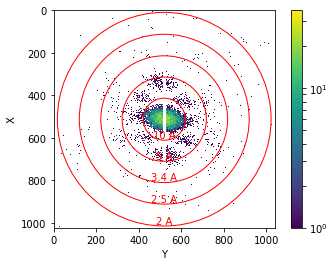

In [9]:
demo(experiment)

# SASE Beam, SPI

In [10]:
Beam = ps.Beam

In [11]:
class MyBeam(Beam):
    def __init__(self, mu=None, sigma=None, n_spikes=0,
                 *args, **kargs):
        super(MyBeam, self).__init__(**kargs)
        self.mu = mu
        self.sigma = sigma
        self.n_spikes = n_spikes
        
    def get_highest_wavenumber_beam(self):
        """
        For variable/polychromatic beam to return highest wavenumber.
        """
        return Beam(
            wavenumber=self.wavenumber*1.5,
            focus_x=self._focus_xFWHM,
            focus_y=self._focus_yFWHM,
            focus_shape=self._focus_shape,
            fluence=self.get_photons_per_pulse()
        )
    
    def generate_new_state(self):
        """
        For variable beam to return specific instance.
        """
        # If simple Beam, return itself.
        # Variable beams should return simple one.
        samples = np.random.normal(mu, sigma, n_spikes)
        
        gkde = stats.gaussian_kde(samples)

        gkde.set_bandwidth(bw_method=0.25)

        xs = np.linspace(self.mu-50, self.mu+50, self.n_spikes+1)

        density, bins, patches = plt.hist(samples, bins=xs, histtype=u'step', density=True)
        ind = np.where(density == np.amax(density))
        density[ind[0][0]] *= 1.5
        density_renorm = density / density.sum()
        
        plt.plot(xs, gkde(xs),'r')
        
        photon_energy = np.linspace(self.mu-50, self.mu+50, self.n_spikes+1).tolist()
        fluences = (self.get_photons_per_pulse()*density_renorm/density_renorm.sum())
        
        return [
            Beam(
                photon_energy=photon_energy[i],
                focus_x=self._focus_xFWHM,
                focus_y=self._focus_yFWHM,
                focus_shape=self._focus_shape,
                fluence=fluences[i])
            for i in range(self.n_spikes)
        ]

In [12]:
mu, sigma = 7120, 10 # mean and standard deviation
n_spikes = 100
sase = MyBeam(mu, sigma, n_spikes, fname=ROOT_DIR+'/input/beam/amo86615.beam')
sase._n_phot *= 100
print "number of photons per shot: ", sase._n_phot

number of photons per shot:  1e+14


In [13]:
experiment = ps.SPIExperiment(det, sase, particle)

In [ ]:
demo(experiment)

('counter', 0)
('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]))
('photons_stack', array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]))
('photons_stack', array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.,

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]))
('photons_stack', array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.,

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]))
('photons_stack', array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.,

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]))
('photons_stack', array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.,

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]))
('photons_stack', array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.,

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]))
('photons_stack', array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.,

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]))
('photons_stack', array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.,

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 2, 2, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]))
('photons_stack', array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.,

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 2, 0],
        [0, 0, 0, ..., 0, 1, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]]]))
('photons_stack', array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 1, 2, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 2, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 3, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 2, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 1, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 1, 4, ..., 0, 0, 0]]]))
('photons_stack', array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 2],
        [0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 3, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [2, 0, 3, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 3, 2],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 2, 2, ..., 0, 0, 0],
        [2, 1, 0, ..., 0, 0, 0],
        [0, 0, 2, ..., 0, 0, 0]]]))
('photons_stack', array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]))
('photons_stack', array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0

('group_photons', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]))
('photons_stack', array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0